In [1]:
import PIL
import time
import math
import copy
import torch
import random
import glob as gb
import torchvision
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import resnet50_128_redesign as model
from PIL import Image
from tqdm import tqdm,trange
from torchsummary import summary
from torch.optim import lr_scheduler
from sklearn.metrics import confusion_matrix
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils import clip_grad_norm_, clip_grad_value_
from torchvision import transforms, utils
from sklearn.metrics import accuracy_score
from DataProcessing import process_dataloder
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
plt.ion()   # interactive mode

In [ ]:
train_loader, test_loader = process_dataloder()

In [4]:
def training(phase, model, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    nb_classes = 4
    confusion_matrix = torch.zeros(nb_classes, nb_classes)
    if phase == 'train':
        dataloaders = train_loader
    else dataloaders = test_loader
    # Iterate over data.        
    for inputs, labels in dataloaders:            
        inputs = inputs.to(device)            
        labels = labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward
        # track history if only in train
        with torch.set_grad_enabled(phase == 'train'):
            
            outputs = model(inputs)            
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, preds)    
            
            # backward + optimize only if in training phase
            if phase == 'train':
                loss.backward()
#                 clip_grad_norm_(model.parameters(), 5)
                optimizer.step()  
            if phase == 'test':              
                with torch.no_grad():
#                     for t, p in zip(labels.view(-1), preds.view(-1)):
#                         confusion_matrix[t.long(), p.long()] += 1

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data) 
        
    if phase == 'test':
        print(confusion_matrix)

    return running_loss, running_corrects     

In [5]:
def epoch_mode(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    logs = []
    Acc = {'train':[],'test':[]}
    Los = {'train':[],'test':[]}
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):        
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            running_loss, running_corrects = training(phase, model, criterion, optimizer)
            if phase == 'train':
                scheduler.step()
                lr_sched_test = scheduler.get_lr()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
            phase, epoch_loss, epoch_acc))
            
            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())      
            Acc[phase].append(epoch_acc)
            Los[phase].append(epoch_loss)
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best test Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, Acc, Los

In [9]:
#Freeze layers before classifier
def freezing(model, features_layers):
    lay_mark = 0;
    para_list = []
    for param in modelRes50.parameters():
        if lay_mark > features_layers:
            para_list.append(param)
        if lay_mark <= features_layers:
            param.requires_grad = False
        lay_mark += 1
    return model, para_list

In [13]:
#download the pre-trained model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
modelRes50 = model.resnet50_128(weights_path='./model/resnet50_128.pth')
modelRes50.add_module("feat_extract1",nn.Conv2d(128, 64, kernel_size=[1, 1], stride=(1, 1), bias=False))
modelRes50.add_module("feat_extract2",nn.Conv2d(64, 4, kernel_size=[1, 1], stride=(1, 1), bias=False))
modelRes50.add_layers([modelRes50.feat_extract1, modelRes50.feat_extract2])
modelRes50, para_list = freezing(modelRes50, features_layers)
modelRes50 = modelRes50.to(device)
features_layers = 91

In [14]:
#final layer are being optimized 
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(para_list, lr=0.00035, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
# # Parameters
# lr_max = 1.2*10e-2
# factor = 6
# num_epochs=75
# end_lr = lr_max
# iter=0
# total_logs = []
# features_layers = 158
# step_size = 4*len(dataloaders["train"])
# Epo = [x for x in range(num_epochs)]

# # Do 3 sequential runs

# # Instantiate the model 
# modelRes50 = model.resnet50_128(weights_path='./model/resnet50_128.pth')
# modelRes50.add_module("feat_extract1",nn.Conv2d(128, 64, kernel_size=[1, 1], stride=(1, 1), bias=False))
# modelRes50.add_module("feat_extract2",nn.Conv2d(64, 4, kernel_size=[1, 1], stride=(1, 1), bias=False))
# modelRes50.add_layers([modelRes50.feat_extract1, modelRes50.feat_extract2])

# modelRes50, para_list = freezing(modelRes50, features_layers)
# modelRes50 = modelRes50.to(device)

# # Define the loss function
# criterion = nn.CrossEntropyLoss()

# # Define the optimizer 

# optimizer_ft = optim.SGD(para_list, lr=1.)    
# clr = cyclical_lr(step_size, min_lr=end_lr/factor, max_lr=end_lr)
# exp_lr_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer_ft, [clr])
# modelRes50, Acc, Los = epoch_mode(modelRes50, criterion, optimizer_ft, exp_lr_scheduler, num_epochs) 

# plt.title('Accuracy and Loss for testing and testing')
# plt.subplot(2, 1, 1)   
# plt.plot(Epo, Acc["train"], 'g--')
# plt.plot(Epo, Acc["test"], 'r--')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend('Training accuracy', 'Testing accuracy')

# plt.subplot(2, 1, 2)
# plt.plot(Epo, Los["train"], 'y--')
# plt.plot(Epo, Los["test"], 'b--')    
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend('Training loss', 'Testing loss')
# plt.show()

In [15]:
modelRes50, Acc, Los = epoch_mode(modelRes50, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=5)

Epoch 0/4
----------
train Loss: 0.0181 Acc: 0.2494
tensor([[1.6000e+01, 2.0700e+03, 4.4100e+02, 1.6330e+03],
        [0.0000e+00, 9.8400e+02, 1.9500e+02, 2.4210e+03],
        [1.0000e+00, 1.0030e+03, 3.6700e+02, 3.2370e+03],
        [0.0000e+00, 1.1220e+03, 1.3200e+02, 2.3780e+03]])
test Loss: 0.0428 Acc: 0.2341
Epoch 1/4
----------
train Loss: 0.0009 Acc: 0.2417
tensor([[2.0000e+00, 2.7510e+03, 6.0000e+00, 1.4010e+03],
        [0.0000e+00, 2.0420e+03, 0.0000e+00, 1.5580e+03],
        [0.0000e+00, 2.4950e+03, 0.0000e+00, 2.1130e+03],
        [0.0000e+00, 1.9470e+03, 2.0000e+00, 1.6830e+03]])
test Loss: 0.0108 Acc: 0.2329
Epoch 2/4
----------
train Loss: 0.0000 Acc: 0.2446
tensor([[3.0000e+00, 2.7150e+03, 1.0000e+00, 1.4410e+03],
        [0.0000e+00, 1.9880e+03, 0.0000e+00, 1.6120e+03],
        [0.0000e+00, 2.4470e+03, 0.0000e+00, 2.1610e+03],
        [0.0000e+00, 1.8780e+03, 3.0000e+00, 1.7510e+03]])
test Loss: 0.0218 Acc: 0.2339
Epoch 3/4
----------
train Loss: 0.0000 Acc: 0.2446
ten

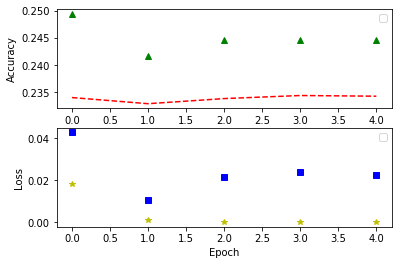

In [17]:
Epo = [x for x in range(5)]
    
plt.title('Accuracy and Loss for testing and testing')
plt.subplot(2, 1, 1)   
plt.plot(Epo, Acc["train"], 'g^')
plt.plot(Epo, Acc["test"], 'r--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend('Training accuracy', 'Testing accuracy')

plt.subplot(2, 1, 2)
plt.plot(Epo, Los["train"], 'y*')
plt.plot(Epo, Los["test"], 'bs')    
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend('Training loss', 'Testing loss')
plt.show()

In [18]:
nb_classes = 4

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['test']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = modelRes50(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
print(class_names)
print(confusion_matrix)

['negative', 'positive', 'surprise', 'non_micro-expression']
tensor([[   3., 2713.,    4., 1440.],
        [   0., 1987.,    0., 1613.],
        [   0., 2441.,    0., 2167.],
        [   0., 1863.,    8., 1761.]])
